# To train up a Model with the .wav dataset. Run through this Notebook

In [ ]:
#Download Dataset
!wget https://zenodo.org/record/4682101/files/dataset.zip?download=1 

In [ ]:
#Unzip Dataset
!unzip dataset.zip 

In [1]:
# import Required Libraries
from matplotlib import cm
import os.path
import random
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1.keras.backend as K
from feature_extract import *
from train import Model
from tflite_op import *
from feature_extract import *

if tf.test.is_built_with_cuda():
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    sess = InteractiveSession(config=config)
else:
    sess = InteractiveSession()

In [2]:
#!unzip dataset.zip > 0
""" 
    Read Samples directory into an Array Excluding irrelivant directories
"""
data_dir = pathlib.Path('dataset')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'validation_list.txt']
commands = commands[commands != "_background_noise_"]
commands = commands[commands != 'LICENSE']
commands = commands[commands != '.DS_Store']
commands = commands[commands != 'README.md']
commands = commands[commands != 'testing_list.txt']
commands = commands[commands != '.ipynb_checkpoints']
commands = commands[commands != 'silence']
commands = list(commands)
print("Number of Commands: ", len(commands))

Number of Commands:  38


In [3]:
!rm -r dataset/_background_noise_
!rm -r dataset/silence
model_dir = pathlib.Path('checkpoints')

rm: cannot remove 'dataset/_background_noise_': No such file or directory
rm: cannot remove 'dataset/silence': No such file or directory


In [4]:
search_path = os.path.join(data_dir, "*", '*.wav') # Collect all available ./wav files into a python list
files = gfile.Glob(search_path)
np.random.shuffle(files)

In [5]:
# Divide file samples into training, Validation and Testing

n_of_samples = len(files)
train_percent = int(n_of_samples * 0.7) # Percentage of Data available for Training
val_percent = int((n_of_samples - train_percent)*0.7) # Percentage of Data available for Validation
test_percent = int((n_of_samples - train_percent)*0.3) # Percentage of Data available for Testing

train_files = files[:train_percent]
val_files = files[train_percent:val_percent+train_percent]
test_files= files[val_percent+train_percent:]

print("training samples: ", len(train_files))
print("validation Samples: ", len(val_files))
print("test Samples: ", len(test_files))

training samples:  75098
validation Samples:  22529
test Samples:  9656


## Create Model and Model Layers. You can increase the CNN filters to desired values to increase accuracy

In [6]:
model = Model(first_conv_filter = 128, second_conv_filter = 64, model_dir="checkpath", commands= commands, sess = sess) # Create Model

In [7]:
#Comment out to load from checkpoint, you can also pass in path to checkpoint
#model.load_checkpoint()
#model.load_checkpoint(path="model/model_checkpoint.ckpt-10000") 

In [8]:
# Train Model
history = model.train(learn_rate=[0.01, 0.0001], dropout_rate=0.5, save_step=1000, eval_step=1000,
                      batch_size=256, training_time=15000, rate_step=10000, display_step=1000, 
                      train_data=train_files, Validation_data=val_files)

INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0', '/replica:0/task:0/device:GPU:1')
Step #0: learning rate 0.010000, accuracy 2.7%, cross entropy 4.647210
Step 0: Validation accuracy = 3.7% (Val Size=512), Validation loss = 3.979101
Step #1000: learning rate 0.010000, accuracy 72.3%, cross entropy 0.877669
Step 1000: Validation accuracy = 74.8% (Val Size=512), Validation loss = 1.163367
Step #2000: learning rate 0.010000, accuracy 80.9%, cross entropy 0.585962
Step 2000: Validation accuracy = 81.1% (Val Size=512), Validation loss = 0.764981
Step #3000: learning rate 0.010000, accuracy 82.8%, cross entropy 0.574525
Step 3000: Validation accuracy = 80.9% (Val Size=512), Validation loss = 0.717540
Step #4000: learning rate 0.010000, accuracy 89.1%, cross entropy 0.370905
Step 4000: Validation accuracy = 85.4% (Val Size=512), Validation loss = 0.631443
Step #5000: learning rate 0.010000, accuracy 87.1%, cross entropy 0.388354
Step 5000: Validation accur

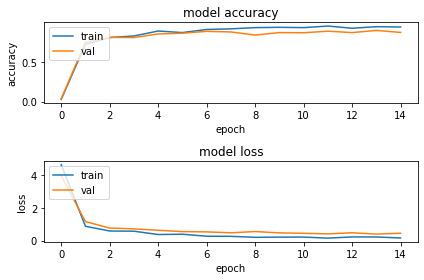

In [23]:
plt.subplot(211)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')# summarize history for loss 



plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
data, label = model.get_next_batch(2000, file_path = test_files) # Grab 2000 files from Test files for Evaluation

In [27]:
model.evaluate(data, label) # Evaluate on Data # Please note 

Validation accuracy = 87.7%, Validation loss = 0.439979


(0.877, 0.43997857)

# Let us See the Accuracy on Test Samples

In [35]:
grab = int(len(test_files)/5)
fro = 0
correct = 0
for i in range(5):
    data, label = model.get_next_batch(int(len(test_files)/5), test_files[fro:grab])
    predictions = model.predict(data)[0]
    correct+=np.sum(predictions == label)
    fro = grab
    grab+=int(len(test_files)/5)
print(' Model accuracy is %f%% (Number of test samples=%d)' % (
        (correct * 100) / len(test_files), len(test_files)))

 Model accuracy is 87.572494% (Number of test samples=9656)


# Here we are Saving the Model for a reload using tf.saved_model.load, Serving Signature is set to Default

In [36]:
model.save_pb_model(file_name = "Model/model_pb",  first_conv_filter=128, second_conv_filter=64, frequency_size=40, time_size=49, )

INFO:tensorflow:Restoring parameters from checkpath/model_checkpoint.ckpt-15000
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Model/model_pb/saved_model.pb


# The Next Lines of code introduces you to TensorFlow LITE (TFLITE) and Tensorflow LITE MICRO (TFLITE MICRO)
### TFLITE for Android Devices and Micro-Computers
### TFLITE Micro for Micro-controllers and Embedded Devices with low power and generally requiring int8 computations

In [37]:
# directories and tflite micro libraries
from tflite_op import *
rep_size = 100
float_model_tflite="Model/tfFloat"
quant_model_tflite= "Model/tflite"
pb_model_dir = "Model/model_pb"
tflite_micro = "Model/tflite_micro.cc"

In [38]:
# See tflite_op for implementation. Save TFLITE MODEL FOR FLOAT VALUE COMPUTATION
save_float_model(model_path=pb_model_dir, save_path=float_model_tflite)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Float model is 6259680 bytes


In [39]:
# # See tflite_op for implementation. Save TFLITE MODEL FOR INT8 VALUE COMPUTATION
save_quantized_model(model_path=pb_model_dir, save_path=quant_model_tflite, rep_files=test_files, rep_data=100)

INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_3:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow:Tensor's key in saved_model's tensor_map: predictions


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 38), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Quantized model is 1574064 bytes


# Now Let us Test the Accuracy from TFLITE... See Implmentation in tflite_op.py

In [40]:
# Use our data from our wanted commands
commands_files =[]
for com in ["on", "off", "heater", "fan", "light"]:
    search_path = os.path.join("dataset", com, '*.wav')
    file = gfile.Glob(search_path)
    np.random.shuffle(file)
    commands_files += file
# Preprocess using the Micro_process Implementation
data, labels = model.get_next_batch(len(commands_files), commands_files)

# Great Result, 93% on our Wanted words with TFLITE saved as Float: See Result below

In [42]:


correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_float(data[i], float_model_tflite) == labels[i])
   

print(' Float model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 Float model accuracy is 93.984962% (Number of test samples=9044)


# Great Result, 93% on our Wanted words with TFLITE saved as INT8: See Result below

In [43]:
correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_quantized(data[i], quant_model_tflite ) == labels[i])
   

print(' Int8 model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 Int8 model accuracy is 93.841221% (Number of test samples=9044)


## For Embedded Devices, Let us covert to TFLITE Micro

In [44]:
!xxd -i {quant_model_tflite} > {tflite_micro}
REPLACE_TEXT = quant_model_tflite.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {tflite_micro}

# Holla!!! You have Just Created a MODEL that can be deployed for Speech Recognition on Embedded Devices. Next is to locate the file Model/tflite_micro.cc and this is the Model for deployment to our Device

In [56]:
# You can also copy the Parameters by running this Cell
# !cat {MODEL_TFLITE_MICRO}  

In [45]:
!zip model.zip -r Model

  adding: Model/ (stored 0%)
  adding: Model/tflite_micro.cc (deflated 77%)
  adding: Model/tflite (deflated 16%)
  adding: Model/model_pb/ (stored 0%)
  adding: Model/model_pb/variables/ (stored 0%)
  adding: Model/model_pb/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Model/model_pb/variables/variables.index (deflated 37%)
  adding: Model/model_pb/saved_model.pb (deflated 87%)
  adding: Model/tfFloat (deflated 7%)
  adding: Model/.ipynb_checkpoints/ (stored 0%)
  adding: Model/.ipynb_checkpoints/tflite_micro-checkpoint.cc (deflated 77%)


In [49]:
!zip checkpoint.zip -r checkpath 

  adding: checkpath/ (stored 0%)
  adding: checkpath/model.pbtxt (deflated 95%)
  adding: checkpath/model_checkpoint.ckpt-12000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-15000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-13000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-15000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-15000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-11000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-13000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-14000.meta (deflated 87%)
  adding: checkpath/checkpoint (deflated 80%)
  adding: checkpath/model_checkpoint.ckpt-14000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-13000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-11000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-11000.meta (deflated 87%)
  adding: ch

In [48]:
!unzip check.zip -d work


Archive:  check.zip
   creating: work/model/
  inflating: work/model/model.pbtxt  
  inflating: work/model/model_checkpoint.ckpt-7000.index  
  inflating: work/model/model_checkpoint.ckpt-8000.meta  
  inflating: work/model/model_checkpoint.ckpt-9000.meta  
  inflating: work/model/model_checkpoint.ckpt-9000.index  
  inflating: work/model/model_checkpoint.ckpt-8000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-7000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-8000.index  
  inflating: work/model/checkpoint   
  inflating: work/model/model_checkpoint.ckpt-9000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-10000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-6000.meta  
  inflating: work/model/model_checkpoint.ckpt-6000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-7000.meta  
  inflating: work/model/model_checkpoint.ckpt-6000.index  
  inflating: work/model/model_checkpoint.ckpt